In [3]:
# Import all necessary libraries.
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from scipy.special import expit
import math as m
import matplotlib.pyplot as plt

In [4]:
seed = 42
np.random.seed(seed)

<bound method NDFrame.head of      label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]>


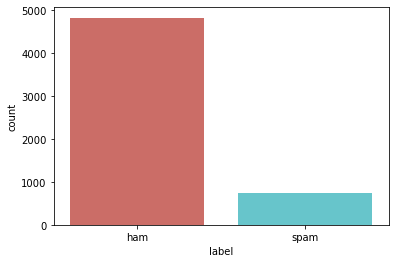

In [5]:
# Read SMS data base with pandas.
# Public set of SMS messages for mobile phone spam research.
# It is composed of 5574 tagged messages (spam or ham).
file='../../../../data/sms.tsv'
sms = pd.read_table(file, header=None, names=['label', 'message'])

print(sms.head)

sns.countplot(x='label', data=sms, palette='hls')
plt.show()

In [6]:
# Convert label to a numerical variable
sms['label_num'] = sms.label.map({'ham':0, 'spam':1})

# Create feature and label vectors.
x = sms.message

y = np.zeros((len(sms.label_num),1))
y[:,0] = sms.label_num

In [7]:
# Split array into random train and test subsets. By defult test_size=0.25.
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed)

In [8]:
# Convert a collection of text documents into a matrix of token counts.
# Um objeto da classe CountVectorizer cria uma matriz registrando 
# o número de vezes (frequência) com que cada palavra aparece na mensagem. 
vect = CountVectorizer()

# Learn the vocabulary dictionary and return term-document matrix.
x_train_dtm = vect.fit_transform(x_train)
x_train_dtm = np.c_[np.ones((len(y_train), 1)), x_train_dtm.toarray()]

# Transform document into document-term matrix.
x_test_dtm = vect.transform(x_test)
x_test_dtm = np.c_[np.ones((len(y_test), 1)), x_test_dtm.toarray()]

In [9]:
def error_function(x, a, y):
    h = expit(x.dot(a))
    error = -(1/len(y))*np.sum( y.T.dot(np.log(h)) + (1-y).T.dot(np.log((1-h) )) )
    return error

def classifier(x, a):
    h = expit(x.dot(a))
    c = np.zeros((len(h), 1))
    for i in range(0, len(h)):
        if(h[i] >= 0.5):
            c[i,0] = 1.0
    return c

In [10]:
# Batch gradient descent solution.

# learning rate.
alpha = 0.9
# Maximum number of iterations.
n_iterations = 5000

# Random initialization of parameters.
a = np.random.randn(x_train_dtm.shape[1],1)

# Create array for storing error values.
Jgd = np.zeros(n_iterations+1)
Jgd_v = np.zeros(n_iterations+1)

# Calculate initial error.
Jgd[0] = error_function(x_train_dtm, a, y_train)
Jgd_v[0] = error_function(x_test_dtm, a, y_test)

# Batch gradient-descent loop.
minimum_val_error = float("inf")
iteration = 0
error = 1
while iteration < n_iterations:
    gradients = -1/len(y_train)*x_train_dtm.T.dot(y_train - expit(x_train_dtm.dot(a)) )
    a = a - alpha * gradients
    Jgd[iteration+1] = error_function(x_train_dtm, a, y_train)
    Jgd_v[iteration+1] = error_function(x_test_dtm, a, y_test)
    error = np.abs(Jgd[iteration+1] - Jgd[iteration])
    if(Jgd_v[iteration+1] < minimum_val_error):
        minimum_val_error = Jgd_v[iteration+1]
        a_min = a        
    iteration = iteration + 1

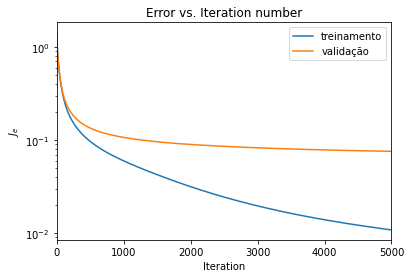

In [11]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

In [11]:
print(minimum_val_error)
y_pred_class = classifier(x_test_dtm, a_min)

0.07578360243645071


In [12]:
# Calculate accuracy of class predictions.
metrics.accuracy_score(y_test, y_pred_class)

0.9820531227566404

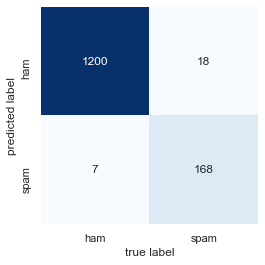

In [13]:
# Plot the confusion matrix
mat = confusion_matrix(y_test, y_pred_class)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['ham','spam'], yticklabels=['ham','spam'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()